Saving POWER_Point_Monthly_20230101_20251231_000d53N_037d89E_LST.csv to POWER_Point_Monthly_20230101_20251231_000d53N_037d89E_LST (3).csv
           PARAMETER  YEAR     JAN     FEB     MAR     APR     MAY     JUN  \
0  ALLSKY_SFC_SW_DWN  2023    6.72    7.19    6.43    5.77    6.28    5.88   
1  ALLSKY_SFC_SW_DWN  2024    6.22    6.59    6.96    5.98    6.23    6.10   
2  ALLSKY_SFC_SW_DWN  2025 -999.00 -999.00 -999.00 -999.00 -999.00 -999.00   
3               RH2M  2023   53.22   45.42   50.73   73.29   67.49   64.99   
4               RH2M  2024   60.31   67.41   61.16   72.81   67.29   55.26   

      JUL     AUG     SEP     OCT     NOV     DEC     ANN  
0    5.91    6.36    6.66    6.14    4.95    5.95    6.18  
1 -999.00 -999.00 -999.00 -999.00 -999.00 -999.00 -999.00  
2 -999.00 -999.00 -999.00 -999.00 -999.00 -999.00 -999.00  
3   59.43   55.31   51.80   58.67   82.78   74.48   61.53  
4   56.69   54.99   49.13   47.28   69.20   60.55   60.12  
PARAMETER  YEAR  MONTH_NUM  ALLSK

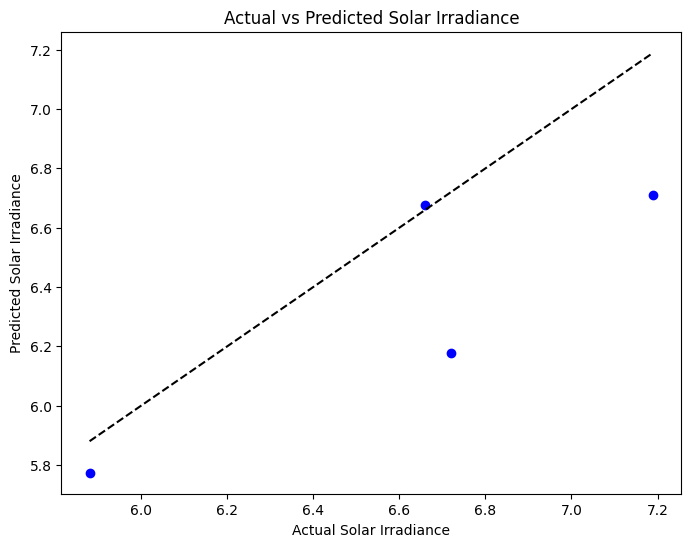

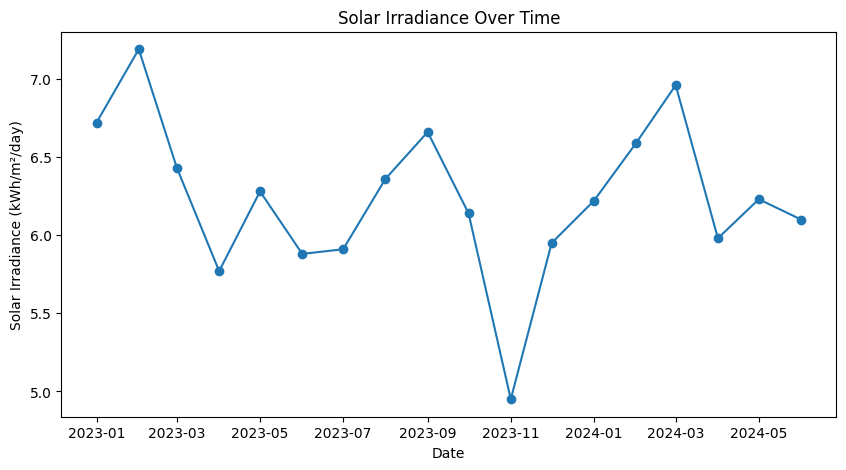

In [16]:
# 1. Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 2. Upload file
from google.colab import files
uploaded = files.upload()

filename = list(uploaded.keys())[0]
df = pd.read_csv(filename, skiprows=12)

# 3. Check structure
print(df.head())

# 4. Melt wide to long format
df_long = pd.melt(df, id_vars=["PARAMETER", "YEAR"],
                  value_vars=["JAN", "FEB", "MAR", "APR", "MAY", "JUN", "JUL",
                              "AUG", "SEP", "OCT", "NOV", "DEC"],
                  var_name="MONTH", value_name="VALUE")

# 5. Convert MONTH to number
month_mapping = {'JAN':1, 'FEB':2, 'MAR':3, 'APR':4, 'MAY':5, 'JUN':6,
                 'JUL':7, 'AUG':8, 'SEP':9, 'OCT':10, 'NOV':11, 'DEC':12}
df_long['MONTH_NUM'] = df_long['MONTH'].map(month_mapping)

# 6. Pivot to have all parameters as columns
df_pivot = df_long.pivot_table(index=["YEAR", "MONTH_NUM"],
                                columns="PARAMETER",
                                values="VALUE").reset_index()

# 7. Replace missing values (-999) and drop missing
df_pivot = df_pivot.replace(-999, np.nan)
df_pivot = df_pivot.dropna()

# 8. Create full date column
df_pivot['DATE'] = pd.to_datetime(df_pivot['YEAR'].astype(str) + '-' + df_pivot['MONTH_NUM'].astype(str))

# 9. Preview cleaned data
print(df_pivot.head())

# 10. Define features and target
features = ['T2M', 'RH2M', 'WS2M']
target = 'ALLSKY_SFC_SW_DWN'

X = df_pivot[features]
y = df_pivot[target]

# 11. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 12. Build model
model = LinearRegression()
model.fit(X_train, y_train)

# 13. Predict
y_pred = model.predict(X_test)

# 14. Evaluate
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\nModel Performance:")
print("MAE:", mae)
print("RMSE:", rmse)
print("R² Score:", r2)

# 15. Plot Actual vs Predicted
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel('Actual Solar Irradiance')
plt.ylabel('Predicted Solar Irradiance')
plt.title('Actual vs Predicted Solar Irradiance')
plt.show()

# 16. Plot Solar Irradiance over time
plt.figure(figsize=(10,5))
plt.plot(df_pivot['DATE'], df_pivot['ALLSKY_SFC_SW_DWN'], marker='o')
plt.xlabel('Date')
plt.ylabel('Solar Irradiance (kWh/m²/day)')
plt.title('Solar Irradiance Over Time')
plt.show()
